In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from timeit import default_timer as timer

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [34]:
def normalize(x): return x / np.linalg.norm(x)

def K_OMP(Psi, K, Theta, X, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""

    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    n = np.shape(Psi)[0]
    
    condition_numbers = [[] for i in range(n)]
    if is_sem: F = [i * (n + 1) for i in range(n)]
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas, Ws = [[] for _ in range(n)], [], np.zeros((n, n)), []
    
    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X]

    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
        # stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: 
            break

        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n

        if row not in Lambda[col]: Lambda[col].append(row)
        else: print("A")
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            if len(idx) >= T - 1: print("I FORESEE ISSUES.")
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)
            F.append(row * n + col)
            
            # update betas
            print(f"Shape of Psi {np.shape(Psi_F)}.")
            print(Psi_F)
            print(f"Condition Number: {np.linalg.cond(Psi_F)}.")
            condition_numbers[col].append(np.linalg.cond(Psi_F))
            if np.linalg.cond(Psi_F) > 1e12:
                betas[np.array(idx)[:, None], col] = np.linalg.pinv(Psi_F) @ K[np.array(idx)[:, None], col]
            else:
                betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
                
            # compare inverse and pseudoinverse
            # print(f"{round(np.linalg.norm(np.linalg.inv(Psi_F) - np.linalg.pinv(Psi_F), 'f'), 12)}.")
            
            Ws.append(betas.copy())
            
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            if len(np.nonzero(betas)[0]) >= max_coefs: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
#         # check residual squared
#         print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
#         print(row, col)

        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            # break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{gains}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, Ws, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]), condition_numbers


### Investigating the Pseudo-Inverse Problem
Using OMP, we will need to compute the coefficients of column $W_{\cdot, j}$ restricted to indices $F \subseteq \{1, \ldots, p\}$. This corresponds to the ordinary least squares solution $$W_{F, j} = \left(X_F X_F^T\right)^{-1} X_F Y_F.$$ Note that $$X \in \mathbb{R}^{T \times p}.$$
Nevertheless, when we have fewer data than we have variables, so $T < p$, then the problem becomes ill posed. 

Nevertheless, when we are only working with $\Psi$ containing all $p (p + 1) / 2$ inner products. Why would this be badly invertible when $T < p$? We did not see this issue when experimenting with SEM. Nevertheless, we did encounter Invertibility problems.

Also, most situations for OMP are when $T < p$, i.e., the number of variables is much larger than the number of samples, so I do not think we need to worry.

### Example 1: $p = 2$, $T = p + 1 = 3$.

[[0.85 0.  ]
 [0.85 0.85]]


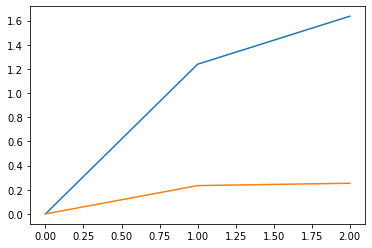

In [37]:
p, s, T = 2, 3, 3

# generate A, X
A_true = np.abs(h.generate_A(p, s, low = 0.85, high = 0.85))
X = h.generate_var_2(T, p, A_true, np.identity(p))

# compute atoms, residuals
atoms = np.array([X[:-1, i] for i in range(p)])
residuals = np.array([X[1:, j] for j in range(p)])

# show results
print(A_true)
plt.plot(X);

In [38]:
# do OMP on Psi and K
W, Ws, _, condition_numbers = K_OMP(atoms.dot(atoms.T), atoms.dot(residuals.T), [np.dot(y.T, y) for y in residuals], atoms, normalize = True, F = [], verbose = True, tol = -0.99)

Shape of Psi (1, 1).
[[1.5348913]]
Condition Number: 1.0.
Iteration 1.

Gains:
[[1.63593259 0.25381818]
 [1.63593259 0.25381818]].

Beta_1:
[[1.32 0.  ]
 [0.   0.  ]].

Residual Squared: [1.5348913  0.11935811].


Shape of Psi (1, 1).
[[1.5348913]]
Condition Number: 1.0.
Iteration 2.

Gains:
[[-1.00000000e+00  2.53818177e-01]
 [ 2.36841547e-16  2.53818177e-01]].

Beta_2:
[[1.32  0.205]
 [0.    0.   ]].

Residual Squared: [1.5348913  0.05493444].


I FORESEE ISSUES.
Shape of Psi (2, 2).
[[1.5348913  0.29037629]
 [0.29037629 0.05493444]]
Condition Number: 8.924955798626418e+16.
Iteration 3.

Gains:
[[-1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00  2.96051934e-17]].

Beta_3:
[[1.32  0.198]
 [0.    0.037]].

Residual Squared: [1.5348913  0.05493444].




The situation happens when we want to invert a matrix $Psi \in \mathbb{R}^{T - 1 \times T - 1}$. For this, we need to have estimated $T - 2$ variables in a certain column, and then we will estimate the $T - 1$th coefficient of column $W_{\cdot, j}$. Therefore, we must be really careful when we estimate the $T - 1$th coefficient. Especially when we are doing cross validation.

### How to Overcome this?
1. Simply do not estimate more than $T - 2$ coefficients, there is not more we can do. Moreover, do we really need more than $T - 2$ coefficients for one single variable? If this would be the case, we would not really have a sparse graph.
2. Use the pseudo-inverse, but that may give some issues as well.

### What is the Effect of using the Pseudo-Inverse?

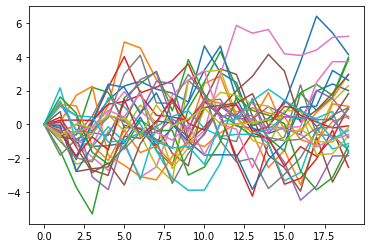

In [39]:
p, s, T = 30, 200, 20
A_true = h.generate_A(p, s, low = 0.3, high = 0.3)
for i in range(p):
    A_true[i][i] = 0.5
X = h.generate_var_2(T, p, A_true, np.identity(p))

atoms = np.array([X[:-1, i] for i in range(p)])
residuals = np.array([X[1:, j] for j in range(p)])

plt.plot(X);

In [41]:
# do OMP on Psi and K
W, Ws, _, condition_numbers = K_OMP(atoms.dot(atoms.T), atoms.dot(residuals.T), [np.dot(y.T, y) for y in residuals], atoms, normalize = True, F = [], tol = -0.99)

Shape of Psi (1, 1).
[[215.82351662]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[66.38362208]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[215.82351662]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[103.28593208]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[99.25812098]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[61.88804143]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[66.38362208]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[215.82351662]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[91.41474247]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[61.86391728]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[87.42847639]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[81.58599827]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[61.88804143]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[66.38362208]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[66.38362208]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[51.10979073]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[60.14856106]]

Shape of Psi (3, 3).
[[61.86391728 -2.76914295 20.76946821]
 [-2.76914295 51.10979073  7.89411982]
 [20.76946821  7.89411982 33.11227142]]
Condition Number: 3.6368496718059506.
Shape of Psi (4, 4).
[[33.11227142 -3.7414602  -0.76474249  4.68288981]
 [-3.7414602  32.34101767  4.54728665 20.82776646]
 [-0.76474249  4.54728665 16.5854836  15.43053866]
 [ 4.68288981 20.82776646 15.43053866 99.25812098]]
Condition Number: 7.921459060880747.
Shape of Psi (5, 5).
[[215.82351662  45.92032229 -15.77653599  22.46165966 -38.7159606 ]
 [ 45.92032229  60.14856106  -3.2186261   10.45263023 -24.9036233 ]
 [-15.77653599  -3.2186261    7.06754313  -1.2287881   -1.31180267]
 [ 22.46165966  10.45263023  -1.2287881   16.5854836  -10.47950104]
 [-38.7159606  -24.9036233   -1.31180267 -10.47950104  81.58599827]]
Condition Number: 43.62113963463087.
Shape of Psi (6, 6).
[[215.82351662  45.92032229 -15.77653599  22.46165966 -38.7159606
   20.61872602]
 [ 45.92032229  60.14856106  -3.2186261   10.45263023 -24.

Shape of Psi (4, 4).
[[ 61.86391728  -5.5082608   14.23397432 -20.5362702 ]
 [ -5.5082608   61.88804143 -22.66550634 -26.12792651]
 [ 14.23397432 -22.66550634  39.39713744  13.02003713]
 [-20.5362702  -26.12792651  13.02003713  66.38362208]]
Condition Number: 4.701654380561165.
Shape of Psi (4, 4).
[[215.82351662  32.26889178 -37.53225497  28.88414869]
 [ 32.26889178  29.37220914  -7.80381278  -2.30969127]
 [-37.53225497  -7.80381278  19.1375341  -11.08881346]
 [ 28.88414869  -2.30969127 -11.08881346  49.14710753]]
Condition Number: 22.09993849290547.
Shape of Psi (5, 5).
[[ 61.86391728  -5.5082608   14.23397432 -20.5362702    7.70150025]
 [ -5.5082608   61.88804143 -22.66550634 -26.12792651  -6.71516093]
 [ 14.23397432 -22.66550634  39.39713744  13.02003713   5.98734912]
 [-20.5362702  -26.12792651  13.02003713  66.38362208  -6.66988049]
 [  7.70150025  -6.71516093   5.98734912  -6.66988049   6.75228241]]
Condition Number: 28.44645761388996.
Shape of Psi (2, 2).
[[ 6.75228241  0.10092

Shape of Psi (6, 6).
[[ 60.14856106   1.11512684 -24.9036233   -9.18780719  10.45263023
   31.88758885]
 [  1.11512684  18.9212556   -2.45720587   2.46034497   2.4381409
    2.36473435]
 [-24.9036233   -2.45720587  81.58599827  17.43017796 -10.47950104
  -27.46993881]
 [ -9.18780719   2.46034497  17.43017796  61.88804143   0.22068517
   11.58562612]
 [ 10.45263023   2.4381409  -10.47950104   0.22068517  16.5854836
    6.40806285]
 [ 31.88758885   2.36473435 -27.46993881  11.58562612   6.40806285
   49.14710753]]
Condition Number: 10.796349626261694.
Shape of Psi (6, 6).
[[ 33.11227142  -3.7414602   -0.76474249   4.68288981  14.43879953
    0.29369762]
 [ -3.7414602   32.34101767   4.54728665  20.82776646  -3.66601669
   -4.08809757]
 [ -0.76474249   4.54728665  16.5854836   15.43053866  -0.73449626
   -1.2287881 ]
 [  4.68288981  20.82776646  15.43053866  99.25812098 -11.63322732
    3.25999723]
 [ 14.43879953  -3.66601669  -0.73449626 -11.63322732  29.37220914
   -0.6042553 ]
 [  0.29

Shape of Psi (7, 7).
[[ 66.38362208  10.75612168   7.96108221  17.96810506  38.02537577
   -2.3455228    0.30554816]
 [ 10.75612168  67.51504941  11.85580665  18.50925216 -22.12130914
    2.86856348 -25.0841517 ]
 [  7.96108221  11.85580665  51.10979073  20.27272645  10.45342599
    9.36720774 -17.58731684]
 [ 17.96810506  18.50925216  20.27272645  24.07423084  10.45536074
    1.13089462 -15.09681674]
 [ 38.02537577 -22.12130914  10.45342599  10.45536074  81.58599827
   -2.45720587   7.28081025]
 [ -2.3455228    2.86856348   9.36720774   1.13089462  -2.45720587
   18.9212556   -8.84850907]
 [  0.30554816 -25.0841517  -17.58731684 -15.09681674   7.28081025
   -8.84850907  25.8890237 ]]
Condition Number: 27.454914158455065.
Shape of Psi (8, 8).
[[ 66.38362208  10.75612168   7.96108221  17.96810506  38.02537577
   -2.3455228    0.30554816  15.28936164]
 [ 10.75612168  67.51504941  11.85580665  18.50925216 -22.12130914
    2.86856348 -25.0841517    4.63227939]
 [  7.96108221  11.85580665  

Shape of Psi (7, 7).
[[60.14856106 19.44910942 36.22200093  8.5597357  22.52596059 44.16983988
   1.11512684]
 [19.44910942 67.51504941 10.75316893  6.62250001 29.19753061  5.59824108
   2.86856348]
 [36.22200093 10.75316893 99.25812098  2.59145251 14.10651666 30.61800622
   1.79077291]
 [ 8.5597357   6.62250001  2.59145251  6.75228241  5.98734912  7.70150025
   0.10092645]
 [22.52596059 29.19753061 14.10651666  5.98734912 39.39713744 14.23397432
   9.89287522]
 [44.16983988  5.59824108 30.61800622  7.70150025 14.23397432 61.86391728
   3.82012741]
 [ 1.11512684  2.86856348  1.79077291  0.10092645  9.89287522  3.82012741
  18.9212556 ]]
Condition Number: 34.769378783017544.
Shape of Psi (9, 9).
[[ 51.10979073   5.84020167  -3.7195854   -8.43421748  19.03387526
   39.28220871  10.45342599  11.85580665  -2.89020298]
 [  5.84020167  39.39713744   9.11253995   7.08854879  16.5047186
   50.86258443 -13.74500075  29.19753061  22.52596059]
 [ -3.7195854    9.11253995  28.79565873  -1.44428965

Shape of Psi (13, 13).
[[ 2.15823517e+02  4.59203223e+01 -1.57765360e+01  2.24616597e+01
  -3.87159606e+01  2.06187260e+01  1.69073188e+01  2.88841487e+01
  -3.96523049e+01  9.79330535e+00  1.29034291e+01  3.22688918e+01
   2.19234426e+01]
 [ 4.59203223e+01  6.01485611e+01 -3.21862610e+00  1.04526302e+01
  -2.49036233e+01  6.49719608e+00  8.55973570e+00  3.18875889e+01
  -9.18780719e+00  3.62220009e+01  1.11512684e+00  1.35759493e+01
   4.41698399e+01]
 [-1.57765360e+01 -3.21862610e+00  7.06754313e+00 -1.22878810e+00
  -1.31180267e+00 -4.08809757e+00  6.56168767e-01 -1.87872614e+00
  -2.81144207e+00  3.25999723e+00 -6.90502060e-01 -6.04255297e-01
   5.02039123e-01]
 [ 2.24616597e+01  1.04526302e+01 -1.22878810e+00  1.65854836e+01
  -1.04795010e+01  4.54728665e+00  1.63206678e+00  6.40806285e+00
   2.20685166e-01  1.54305387e+01  2.43814090e+00 -7.34496257e-01
   7.36470893e+00]
 [-3.87159606e+01 -2.49036233e+01 -1.31180267e+00 -1.04795010e+01
   8.15859983e+01 -2.51804306e+00 -8.627207

Shape of Psi (10, 10).
[[ 33.11227142  -3.7414602   -0.76474249   4.68288981  14.43879953
    0.29369762  -3.52945244   4.41192159  -0.42968174 -11.01509495]
 [ -3.7414602   32.34101767   4.54728665  20.82776646  -3.66601669
   -4.08809757  11.98388008  -1.62772015 -15.12282457  10.89120711]
 [ -0.76474249   4.54728665  16.5854836   15.43053866  -0.73449626
   -1.2287881    0.22068517  -1.5772854   -7.45086815   6.40806285]
 [  4.68288981  20.82776646  15.43053866  99.25812098 -11.63322732
    3.25999723  22.81055459  -1.56985499   8.22386751  43.75719822]
 [ 14.43879953  -3.66601669  -0.73449626 -11.63322732  29.37220914
   -0.6042553  -21.24679244  -7.80381278  -5.65884178  -2.30969127]
 [  0.29369762  -4.08809757  -1.2287881    3.25999723  -0.6042553
    7.06754313  -2.81144207  -0.15155713   4.57253938  -1.87872614]
 [ -3.52945244  11.98388008   0.22068517  22.81055459 -21.24679244
   -2.81144207  61.88804143  14.1568588   -0.91010971  11.58562612]
 [  4.41192159  -1.62772015  -1.5

    1.63206678  -1.74867125   8.23256223  -7.275955     6.75228241]]
Condition Number: 107.3539248718793.
Shape of Psi (12, 12).
[[ 87.42847639  22.86412784   6.64599257   9.88863432  13.14745338
    4.83402742 -22.55205952 -30.30917249  -3.71079719  13.42279442
   -8.12527767 -18.46208591]
 [ 22.86412784  82.71844562  -9.19700162   5.4957669   46.84885538
   -2.75081947  10.50559075  -3.51585317  -3.010223   -22.01063914
   25.40461276 -39.77618764]
 [  6.64599257  -9.19700162  33.11227142   0.29369762   4.68288981
   25.05866588  -0.42968174   4.56661111   0.97175888  14.43879953
  -11.01509495   7.89411982]
 [  9.88863432   5.4957669    0.29369762   7.06754313   3.25999723
   -1.31180267   4.57253938  -3.078002     0.65616877  -0.6042553
   -1.87872614  -6.58599737]
 [ 13.14745338  46.84885538   4.68288981   3.25999723  99.25812098
  -29.01397387   8.22386751   4.03711835   2.59145251 -11.63322732
   43.75719822 -42.94145481]
 [  4.83402742  -2.75081947  25.05866588  -1.31180267 -29

Shape of Psi (12, 12).
[[ 6.63836221e+01  1.50926599e+01  1.52893616e+01 -5.18490589e+00
  -2.34552280e+00 -1.05052473e-01  1.76769167e+00 -6.66988049e+00
  -2.11201637e+01 -1.68753444e+01  1.07561217e+01 -3.03773861e+01]
 [ 1.50926599e+01  2.93722091e+01  1.44387995e+01 -3.66601669e+00
   5.25587283e+00 -7.34496257e-01 -6.04255297e-01  3.60465025e+00
  -5.65884178e+00 -2.30049221e+01  1.81557466e+01  6.07014434e+00]
 [ 1.52893616e+01  1.44387995e+01  3.31122714e+01 -3.74146020e+00
   4.17448690e-01 -7.64742495e-01  2.93697617e-01  9.71758884e-01
  -4.29681739e-01 -1.94332665e+01  4.63227939e+00  4.56661111e+00]
 [-5.18490589e+00 -3.66601669e+00 -3.74146020e+00  3.23410177e+01
  -7.98323379e+00  4.54728665e+00 -4.08809757e+00 -1.74867125e+00
  -1.51228246e+01  4.62889172e-01  1.29850605e+01  5.64157391e+00]
 [-2.34552280e+00  5.25587283e+00  4.17448690e-01 -7.98323379e+00
   1.89212556e+01  2.43814090e+00 -6.90502060e-01  1.00926448e-01
   7.52906806e-01 -6.44940669e+00  2.86856348e+00

Shape of Psi (10, 10).
[[ 82.71844562 -22.01063914 -13.33091191  -3.51585317  -3.010223
   -2.75081947  46.84885538   2.69549958   5.4957669  -39.77618764]
 [-22.01063914  29.37220914   5.25587283   6.07014434   3.60465025
    2.45785797 -11.63322732  -3.66601669  -0.6042553   19.03387526]
 [-13.33091191   5.25587283  18.9212556  -12.50412634   0.10092645
   -2.45720587   1.79077291  -7.98323379  -0.69050206   9.36720774]
 [ -3.51585317   6.07014434 -12.50412634  59.06864392   7.80094655
  -20.07600765   4.03711835   5.64157391  -3.078002    -0.26759957]
 [ -3.010223     3.60465025   0.10092645   7.80094655   6.75228241
   -8.62720775   2.59145251  -1.74867125   0.65616877  -2.25819576]
 [ -2.75081947   2.45785797  -2.45720587 -20.07600765  -8.62720775
   81.58599827 -29.01397387  -2.51804306  -1.31180267  10.45342599]
 [ 46.84885538 -11.63322732   1.79077291   4.03711835   2.59145251
  -29.01397387  99.25812098  20.82776646   3.25999723 -42.94145481]
 [  2.69549958  -3.66601669  -7.98

Shape of Psi (12, 12).
[[ 61.86391728  -2.76914295  20.76946821 -10.6341388    7.36470893
    3.82012741  -5.5082608   20.68534295  14.23397432  21.92344263
  -17.94473231   0.79372976]
 [ -2.76914295  51.10979073   7.89411982 -14.93280656  -8.43421748
    9.36720774 -15.78502469 -15.84841524   5.84020167  39.28220871
   10.45342599  -7.00851941]
 [ 20.76946821   7.89411982  33.11227142  -3.7414602   -0.76474249
    0.41744869  -3.52945244 -11.01509495  17.23510238  10.61253587
   25.05866588   4.41192159]
 [-10.6341388  -14.93280656  -3.7414602   32.34101767   4.54728665
   -7.98323379  11.98388008  10.89120711   0.43384748  20.61872602
   -2.51804306  -1.62772015]
 [  7.36470893  -8.43421748  -0.76474249   4.54728665  16.5854836
    2.4381409    0.22068517   6.40806285   7.08854879  22.46165966
  -10.47950104  -1.5772854 ]
 [  3.82012741   9.36720774   0.41744869  -7.98323379   2.4381409
   18.9212556    2.46034497   2.36473435   9.89287522  12.90342914
   -2.45720587  -6.93045548]
 

Shape of Psi (17, 17).
[[ 8.74284764e+01  2.28641278e+01  6.64599257e+00  9.88863432e+00
   1.31474534e+01  4.83402742e+00 -2.25520595e+01 -3.03091725e+01
  -3.71079719e+00  1.34227944e+01 -8.12527767e+00 -1.84620859e+01
  -2.07910468e+01  5.55797646e+01  2.68319905e+00 -1.40485012e+00
   4.54716964e+00]
 [ 2.28641278e+01  8.27184456e+01 -9.19700162e+00  5.49576690e+00
   4.68488554e+01 -2.75081947e+00  1.05055908e+01 -3.51585317e+00
  -3.01022300e+00 -2.20106391e+01  2.54046128e+01 -3.97761876e+01
   3.28025786e+01 -1.27215513e+00  2.69549958e+00 -1.33309119e+01
  -2.25065727e+00]
 [ 6.64599257e+00 -9.19700162e+00  3.31122714e+01  2.93697617e-01
   4.68288981e+00  2.50586659e+01 -4.29681739e-01  4.56661111e+00
   9.71758884e-01  1.44387995e+01 -1.10150950e+01  7.89411982e+00
  -3.52945244e+00  3.65929469e+01 -3.74146020e+00  4.17448690e-01
  -7.64742495e-01]
 [ 9.88863432e+00  5.49576690e+00  2.93697617e-01  7.06754313e+00
   3.25999723e+00 -1.31180267e+00  4.57253938e+00 -3.07800200e

Shape of Psi (16, 16).
[[ 2.15823517e+02  3.22688918e+01 -3.75322550e+01  2.88841487e+01
   1.29034291e+01 -3.87159606e+01  9.79330535e+00 -1.57765360e+01
   1.00542539e+02  1.69073188e+01 -1.54216201e+01 -1.04384054e+02
   2.24616597e+01 -3.96523049e+01  2.06187260e+01  2.19234426e+01]
 [ 3.22688918e+01  2.93722091e+01 -7.80381278e+00 -2.30969127e+00
   5.25587283e+00  2.45785797e+00 -1.16332273e+01 -6.04255297e-01
   1.81557466e+01  3.60465025e+00  1.50926599e+01 -2.30049221e+01
  -7.34496257e-01 -2.12467924e+01 -3.66601669e+00  1.84142748e+01]
 [-3.75322550e+01 -7.80381278e+00  1.91375341e+01 -1.10888135e+01
  -6.93045548e+00  1.68791898e+01 -1.56985499e+00 -1.51557126e-01
  -1.53134024e+01 -7.27595500e+00  8.88069291e+00  1.90824373e+01
  -1.57728540e+00  1.41568588e+01 -1.62772015e+00  7.93729756e-01]
 [ 2.88841487e+01 -2.30969127e+00 -1.10888135e+01  4.91471075e+01
   2.36473435e+00 -2.74699388e+01  4.37571982e+01 -1.87872614e+00
   1.17222145e+01  8.23256223e+00 -3.84800192e+01 

Shape of Psi (16, 16).
[[ 6.63836221e+01  1.50926599e+01  1.52893616e+01 -5.18490589e+00
  -2.34552280e+00 -1.05052473e-01  1.76769167e+00 -6.66988049e+00
  -2.11201637e+01 -1.68753444e+01  1.07561217e+01 -3.03773861e+01
   1.30200371e+01  3.80253758e+01 -2.61279265e+01  8.88069291e+00]
 [ 1.50926599e+01  2.93722091e+01  1.44387995e+01 -3.66601669e+00
   5.25587283e+00 -7.34496257e-01 -6.04255297e-01  3.60465025e+00
  -5.65884178e+00 -2.30049221e+01  1.81557466e+01  6.07014434e+00
   1.65047186e+01  2.45785797e+00 -2.12467924e+01 -7.80381278e+00]
 [ 1.52893616e+01  1.44387995e+01  3.31122714e+01 -3.74146020e+00
   4.17448690e-01 -7.64742495e-01  2.93697617e-01  9.71758884e-01
  -4.29681739e-01 -1.94332665e+01  4.63227939e+00  4.56661111e+00
   1.72351024e+01  2.50586659e+01 -3.52945244e+00  4.41192159e+00]
 [-5.18490589e+00 -3.66601669e+00 -3.74146020e+00  3.23410177e+01
  -7.98323379e+00  4.54728665e+00 -4.08809757e+00 -1.74867125e+00
  -1.51228246e+01  4.62889172e-01  1.29850605e+01 

I FORESEE ISSUES.
Shape of Psi (19, 19).
[[ 8.27184456e+01  4.68488554e+01 -1.33309119e+01  2.54046128e+01
  -2.75081947e+00  5.64985990e+00 -3.81022940e+01 -2.20106391e+01
  -2.25065727e+00  3.35037753e+01  5.49576690e+00  2.69549958e+00
   1.05055908e+01 -3.01022300e+00 -2.23212943e+01  3.28025786e+01
  -9.04061933e+01  1.48505834e+01  7.39882553e+01]
 [ 4.68488554e+01  9.92581210e+01  1.79077291e+00  4.37571982e+01
  -2.90139739e+01  3.62220009e+01  1.07531689e+01 -1.16332273e+01
   1.54305387e+01  4.43033832e+00  3.25999723e+00  2.08277665e+01
   8.22386751e+00  2.59145251e+00 -3.34902305e+01  2.28105546e+01
   9.79330535e+00 -1.56985499e+00  3.35555677e+01]
 [-1.33309119e+01  1.79077291e+00  1.89212556e+01  2.36473435e+00
  -2.45720587e+00  1.11512684e+00  2.86856348e+00  5.25587283e+00
   2.43814090e+00 -8.84850907e+00 -6.90502060e-01 -7.98323379e+00
   7.52906806e-01  1.00926448e-01 -2.34552280e+00  2.46034497e+00
   1.29034291e+01 -6.93045548e+00 -6.44940669e+00]
 [ 2.54046128e

   2.54046128e+01 -3.01022300e+00  8.27184456e+01]]
Condition Number: 3.8347890338572186e+17.
I FORESEE ISSUES.
Shape of Psi (24, 24).
[[ 6.63836221e+01  1.07561217e+01  7.96108221e+00  1.79681051e+01
   3.80253758e+01 -2.34552280e+00  3.05548158e-01  1.52893616e+01
   1.50926599e+01  8.88069291e+00 -1.05052473e-01 -3.34902305e+01
  -1.54216201e+01 -2.28870492e+01  1.76769167e+00 -2.61279265e+01
  -2.11201637e+01 -1.68753444e+01 -7.62341372e+01  4.47439778e+01
  -3.84800192e+01 -6.66988049e+00 -2.23212943e+01  1.30200371e+01]
 [ 1.07561217e+01  6.75150494e+01  1.18558067e+01  1.85092522e+01
  -2.21213091e+01  2.86856348e+00 -2.50841517e+01  4.63227939e+00
   1.81557466e+01 -1.53134024e+01  1.65702834e+01  1.07531689e+01
   1.00542539e+02  1.94491094e+01 -7.06246592e+00 -2.83451401e+01
  -1.79120804e+01 -4.45760695e+01  2.33045652e+01  2.14889803e+00
   1.17222145e+01  6.62250001e+00 -3.81022940e+01  2.91975306e+01]
 [ 7.96108221e+00  1.18558067e+01  5.11097907e+01  2.02727265e+01
   1.

[[ 6.63836221e+01  1.07561217e+01  7.96108221e+00  1.79681051e+01
   3.80253758e+01 -2.34552280e+00  3.05548158e-01  1.52893616e+01
   1.50926599e+01  8.88069291e+00 -1.05052473e-01 -3.34902305e+01
  -1.54216201e+01 -2.28870492e+01  1.76769167e+00 -2.61279265e+01
  -2.11201637e+01 -1.68753444e+01 -7.62341372e+01  4.47439778e+01
  -3.84800192e+01 -6.66988049e+00 -2.23212943e+01  1.30200371e+01
  -3.03773861e+01 -5.18490589e+00 -2.05362702e+01 -5.97054220e+00]
 [ 1.07561217e+01  6.75150494e+01  1.18558067e+01  1.85092522e+01
  -2.21213091e+01  2.86856348e+00 -2.50841517e+01  4.63227939e+00
   1.81557466e+01 -1.53134024e+01  1.65702834e+01  1.07531689e+01
   1.00542539e+02  1.94491094e+01 -7.06246592e+00 -2.83451401e+01
  -1.79120804e+01 -4.45760695e+01  2.33045652e+01  2.14889803e+00
   1.17222145e+01  6.62250001e+00 -3.81022940e+01  2.91975306e+01
   5.54614333e-01  1.29850605e+01  5.59824108e+00 -1.80170261e+01]
 [ 7.96108221e+00  1.18558067e+01  5.11097907e+01  2.02727265e+01
   1.045

I FORESEE ISSUES.
Shape of Psi (25, 25).
[[ 8.74284764e+01  2.28641278e+01  6.64599257e+00  9.88863432e+00
   1.31474534e+01  4.83402742e+00 -2.25520595e+01 -3.03091725e+01
  -3.71079719e+00  1.34227944e+01 -8.12527767e+00 -1.84620859e+01
  -2.07910468e+01  5.55797646e+01  2.68319905e+00 -1.40485012e+00
   4.54716964e+00  2.11725333e+01  4.47439778e+01  6.96553300e+00
   1.63307472e+01 -4.69243680e+01  1.89279548e+00  2.14889803e+00
   3.38364190e+01]
 [ 2.28641278e+01  8.27184456e+01 -9.19700162e+00  5.49576690e+00
   4.68488554e+01 -2.75081947e+00  1.05055908e+01 -3.51585317e+00
  -3.01022300e+00 -2.20106391e+01  2.54046128e+01 -3.97761876e+01
   3.28025786e+01 -1.27215513e+00  2.69549958e+00 -1.33309119e+01
  -2.25065727e+00  3.35037753e+01 -2.23212943e+01  5.64985990e+00
  -2.61561628e+01 -9.04061933e+01  1.48505834e+01 -3.81022940e+01
   7.39882553e+01]
 [ 6.64599257e+00 -9.19700162e+00  3.31122714e+01  2.93697617e-01
   4.68288981e+00  2.50586659e+01 -4.29681739e-01  4.56661111e+

I FORESEE ISSUES.
Shape of Psi (25, 25).
[[ 6.18880414e+01  3.38965647e+01 -3.52945244e+00  1.19838801e+01
  -2.12467924e+01 -6.71516093e+00 -5.71270362e+00 -2.81144207e+00
  -2.26655063e+01  2.28105546e+01 -2.83451401e+01 -9.10109711e-01
  -2.61279265e+01 -2.56943525e+01  2.46034497e+00 -3.96523049e+01
   2.20685166e-01  1.15856261e+01  3.28025786e+01 -1.74305939e+01
  -9.18780719e+00  1.74301780e+01  1.41568588e+01 -5.50826080e+00
  -1.57850247e+01]
 [ 3.38965647e+01  1.03285932e+02 -1.94332665e+01  4.62889172e-01
  -2.30049221e+01 -8.03548877e+00 -5.94099844e+00  1.16592673e+01
  -3.74773310e+01  3.35555677e+01 -4.45760695e+01  3.47760629e+00
  -1.68753444e+01  1.52415299e+00 -6.44940669e+00 -1.04384054e+02
   1.01634004e-01  2.18743997e+01  7.39882553e+01 -1.51088625e+01
   7.77067993e-01  2.56716999e-01  1.90824373e+01  2.74255580e+00
  -4.10778228e+01]
 [-3.52945244e+00 -1.94332665e+01  3.31122714e+01 -3.74146020e+00
   1.44387995e+01  9.71758884e-01  4.56661111e+00  2.93697617e-

I FORESEE ISSUES.
Shape of Psi (26, 26).
[[ 8.27184456e+01 -2.20106391e+01 -1.33309119e+01 -3.51585317e+00
  -3.01022300e+00 -2.75081947e+00  4.68488554e+01  2.69549958e+00
   5.49576690e+00 -3.97761876e+01 -1.27215513e+00  3.35037753e+01
  -2.25065727e+00 -2.61561628e+01 -9.19700162e+00  3.28025786e+01
   1.05055908e+01 -3.81022940e+01  2.28641278e+01 -2.23212943e+01
  -9.04061933e+01  7.39882553e+01 -3.68937832e+01  1.48505834e+01
  -1.34653616e+01  5.64985990e+00]
 [-2.20106391e+01  2.93722091e+01  5.25587283e+00  6.07014434e+00
   3.60465025e+00  2.45785797e+00 -1.16332273e+01 -3.66601669e+00
  -6.04255297e-01  1.90338753e+01  2.14615055e+01 -6.03637499e+00
  -7.34496257e-01  1.65047186e+01  1.44387995e+01 -2.12467924e+01
  -5.65884178e+00  1.81557466e+01  1.34227944e+01  1.50926599e+01
   3.22688918e+01 -2.30049221e+01  8.85676560e+00 -7.80381278e+00
   9.82318444e+00  1.35759493e+01]
 [-1.33309119e+01  5.25587283e+00  1.89212556e+01 -1.25041263e+01
   1.00926448e-01 -2.45720587e+

### Using the Actual Inverse

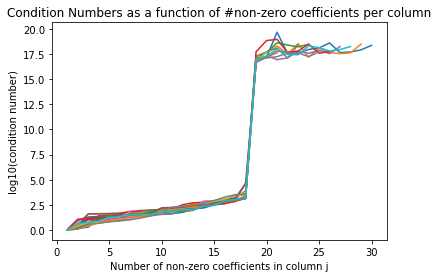

In [59]:
plt.xlabel("Number of non-zero coefficients in column j")
plt.ylabel("log10(condition number)")
plt.title("Condition Numbers as a function of #non-zero coefficients per column")

for c in condition_numbers:
    plt.plot(range(1, len(c) + 1), np.log10(c))

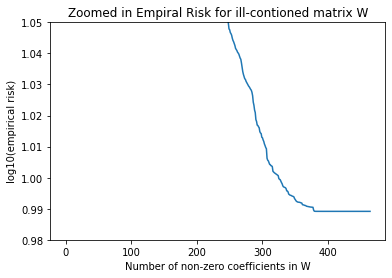

In [68]:
plt.xlabel("Number of non-zero coefficients in W")
plt.ylabel("log10(empirical risk)")
plt.title("Zoomed in Empiral Risk for ill-contioned matrix W")
plt.ylim(0.98, 1.05)
plt.plot([np.log10(h.MSE(W, X)) for W in Ws])

### One row with all entries, others noise.

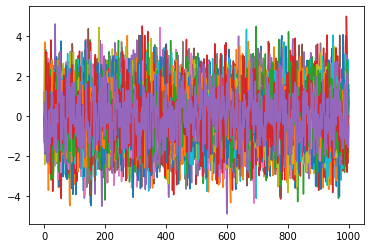

In [99]:
p, s, T = 25, 20, 1000
A_true = h.generate_A(p, s, low = 0.3, high = 0.3)
for i in range(p):
    A_true[i][i] = 0.5
X = h.generate_var_2(T, p, A_true, np.identity(p))

atoms = np.array([X[:-1, i] for i in range(p)])
residuals = np.array([X[1:, j] for j in range(p)])

plt.plot(X);

In [100]:
W, Ws, _, condition_nubmers = K_OMP(atoms.dot(atoms.T), atoms.dot(residuals.T), [np.dot(y.T, y) for y in residuals], atoms, normalize = True, F = [], tol = -0.99, verbose = False, output = True)

Shape of Psi (1, 1).
[[2086.62438643]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[2078.66467326]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1990.67401197]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1858.99465938]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[2005.2896793]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1666.12332605]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1636.36560175]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1664.61762766]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1576.70423394]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1480.42346278]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1582.44234125]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1547.03244389]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1441.12692168]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1461.03361274]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1479.05917844]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1415.798869]]
Condition Number: 1.0.
Shape of Ps

Shape of Psi (3, 3).
[[1576.70423394 -299.12640092  -59.97600381]
 [-299.12640092 1454.4904862    -6.43265751]
 [ -59.97600381   -6.43265751 1206.53032916]]
Condition Number: 1.5668490198711575.
Shape of Psi (8, 8).
[[2005.2896793   244.41735302 -214.16578714 -168.89534389  172.77922744
   113.83942098  -90.4947575    22.25486937]
 [ 244.41735302 1454.4904862    17.51132961   -6.43265751  -44.80515512
    46.7902046   -22.59452436   14.42106462]
 [-214.16578714   17.51132961 1415.03375842  -29.14124837 -310.11363862
  -107.27609144   51.57330341   15.9784344 ]
 [-168.89534389   -6.43265751  -29.14124837 1206.53032916  -72.76135645
    15.8291306    17.73665335   -5.35299407]
 [ 172.77922744  -44.80515512 -310.11363862  -72.76135645 1664.61762766
   437.17373109   51.91772523   -7.44760619]
 [ 113.83942098   46.7902046  -107.27609144   15.8291306   437.17373109
  2086.62438643   11.66747562 -152.48496858]
 [ -90.4947575   -22.59452436   51.57330341   17.73665335   51.91772523
    11.667

Shape of Psi (4, 4).
[[1369.57837391   48.83148446   37.84790149   -1.84186598]
 [  48.83148446 1480.42346278    3.45921811  -20.92771024]
 [  37.84790149    3.45921811 1441.12692168  -21.27149738]
 [  -1.84186598  -20.92771024  -21.27149738 1253.2462588 ]]
Condition Number: 1.2064138165324503.
Shape of Psi (4, 4).
[[1582.44234125 -295.52432985  163.27771272  -45.3493979 ]
 [-295.52432985 1206.53032916 -103.28832724  -15.17440345]
 [ 163.27771272 -103.28832724 1858.99465938  118.17307029]
 [ -45.3493979   -15.17440345  118.17307029 1547.03244389]]
Condition Number: 1.935059904183983.
Shape of Psi (5, 5).
[[1582.44234125 -295.52432985  163.27771272  -45.3493979   -68.89694246]
 [-295.52432985 1206.53032916 -103.28832724  -15.17440345   16.59288275]
 [ 163.27771272 -103.28832724 1858.99465938  118.17307029 -452.41491546]
 [ -45.3493979   -15.17440345  118.17307029 1547.03244389    7.85179275]
 [ -68.89694246   16.59288275 -452.41491546    7.85179275 1636.36560175]]
Condition Number: 2.20

Shape of Psi (6, 6).
[[1664.61762766 -310.11363862  130.47793492  -79.2908489    69.8155397
    95.7380054 ]
 [-310.11363862 1415.03375842   51.05799086   10.40035046   29.74537589
    -3.63842198]
 [ 130.47793492   51.05799086 1356.7885506   -51.02159001   86.41685604
   -20.32732851]
 [ -79.2908489    10.40035046  -51.02159001 1666.12332605   82.38810725
   -30.95494754]
 [  69.8155397    29.74537589   86.41685604   82.38810725 1324.262053
    62.62038924]
 [  95.7380054    -3.63842198  -20.32732851  -30.95494754   62.62038924
  1636.36560175]]
Condition Number: 1.712084888157028.
Shape of Psi (9, 9).
[[ 1.99067401e+03 -4.01669733e+02 -2.19402110e+02 -8.85255353e+01
  -6.70379460e+01 -3.13624965e+00  2.82136529e+01 -3.33298489e+01
  -8.03503733e+01]
 [-4.01669733e+02  1.45449049e+03 -2.47173374e+00  4.67902046e+01
   2.63538917e+01  5.26144785e+01 -2.25945244e+01 -4.48051551e+01
   6.11247803e+01]
 [-2.19402110e+02 -2.47173374e+00  1.35678855e+03  7.34664074e+01
  -1.19334480e+01 -8.

Shape of Psi (12, 12).
[[ 1.30807108e+03  9.87571021e+01  8.44378201e+01 -4.10843663e+01
   6.54652440e+01 -1.09733186e+01 -4.74402416e+01  1.10612470e+02
  -9.50675498e+01 -1.32236981e+01 -2.51879074e+01  2.76789530e+01]
 [ 9.87571021e+01  1.63636560e+03 -3.54523083e+02 -3.72137339e+01
  -9.89834070e+01  1.15179678e+02 -3.63842198e+00 -3.09549475e+01
  -6.88969425e+01 -2.03273285e+01  9.57380054e+01  1.17590728e+01]
 [ 8.44378201e+01 -3.54523083e+02  1.44112692e+03 -1.20600270e+02
   2.61870082e+01 -3.13624965e+00  7.03815220e+01  5.29662255e+01
  -2.20266229e+01 -8.88261018e+01 -1.62195929e+02 -8.19255481e+01]
 [-4.10843663e+01 -3.72137339e+01 -1.20600270e+02  1.41579887e+03
   6.01694307e+01  1.10684237e+01 -8.22385375e+01  1.11902002e+00
   3.43208924e+01 -3.29457992e+01 -5.12010406e+01  2.86071338e+02]
 [ 6.54652440e+01 -9.89834070e+01  2.61870082e+01  6.01694307e+01
   2.00528968e+03 -3.41498337e+02 -2.14165787e+02  2.08119636e+01
   1.07981643e+02  4.37041631e+01  1.72779227e+02

Shape of Psi (7, 7).
[[ 1.63636560e+03 -3.54523083e+02 -3.72137339e+01  1.65928827e+01
  -3.09549475e+01  2.02203342e+01  6.26203892e+01]
 [-3.54523083e+02  1.44112692e+03 -1.20600270e+02 -4.23675430e+01
   5.29662255e+01  3.78479015e+01 -4.06528326e+01]
 [-3.72137339e+01 -1.20600270e+02  1.41579887e+03  1.72530063e+00
   1.11902002e+00  8.45156777e+01 -9.37694207e+01]
 [ 1.65928827e+01 -4.23675430e+01  1.72530063e+00  1.20653033e+03
  -3.55051501e+00  8.82143743e+01 -1.55566690e+00]
 [-3.09549475e+01  5.29662255e+01  1.11902002e+00 -3.55051501e+00
   1.66612333e+03 -6.97679315e+01  8.23881072e+01]
 [ 2.02203342e+01  3.78479015e+01  8.45156777e+01  8.82143743e+01
  -6.97679315e+01  1.36957837e+03 -9.38925244e-02]
 [ 6.26203892e+01 -4.06528326e+01 -9.37694207e+01 -1.55566690e+00
   8.23881072e+01 -9.38925244e-02  1.32426205e+03]]
Condition Number: 1.7992101543192909.
Shape of Psi (7, 7).
[[ 1.36957837e+03  4.88314845e+01  3.78479015e+01 -1.84186598e+00
  -1.01552875e+02 -2.31241018e+00 

Shape of Psi (6, 6).
[[1441.12692168  -88.82610177   52.96622549  -40.65283263  125.5277192
   -15.73761131]
 [ -88.82610177 1356.7885506   -51.02159001   86.41685604   25.88343467
   -58.84187432]
 [  52.96622549  -51.02159001 1666.12332605   82.38810725  -83.1335186
   286.98733941]
 [ -40.65283263   86.41685604   82.38810725 1324.262053      4.42557662
    70.39018646]
 [ 125.5277192    25.88343467  -83.1335186     4.42557662 1547.03244389
    -6.76139297]
 [ -15.73761131  -58.84187432  286.98733941   70.39018646   -6.76139297
  1341.79247915]]
Condition Number: 1.6451967725920849.
Shape of Psi (6, 6).
[[1480.42346278  351.84665138  132.04258637    3.45921811   85.4815497
   -20.92771024]
 [ 351.84665138 1324.262053     86.41685604  -40.65283263   82.38810725
    63.61871765]
 [ 132.04258637   86.41685604 1356.7885506   -88.82610177  -51.02159001
   -27.38404906]
 [   3.45921811  -40.65283263  -88.82610177 1441.12692168   52.96622549
   -21.27149738]
 [  85.4815497    82.38810725  -

  -1.01552875e+02 -2.31241018e+00 -9.38925244e-02  1.36957837e+03]]
Condition Number: 2.8823861232033825.
Shape of Psi (10, 10).
[[ 1.41579887e+03  8.45156777e+01 -9.37694207e+01 -1.20600270e+02
  -5.08687224e+01  9.89306197e+01  1.11902002e+00  5.42700312e+01
  -3.29457992e+01 -3.15908724e+01]
 [ 8.45156777e+01  1.36957837e+03 -9.38925244e-02  3.78479015e+01
   4.88314845e+01 -1.01552875e+02 -6.97679315e+01 -2.31241018e+00
  -1.19334480e+01 -1.84186598e+00]
 [-9.37694207e+01 -9.38925244e-02  1.32426205e+03 -4.06528326e+01
   3.51846651e+02  7.03901865e+01  8.23881072e+01  4.42557662e+00
   8.64168560e+01  6.36187176e+01]
 [-1.20600270e+02  3.78479015e+01 -4.06528326e+01  1.44112692e+03
   3.45921811e+00 -1.57376113e+01  5.29662255e+01  1.25527719e+02
  -8.88261018e+01 -2.12714974e+01]
 [-5.08687224e+01  4.88314845e+01  3.51846651e+02  3.45921811e+00
   1.48042346e+03  6.27829638e+01  8.54815497e+01  3.91658725e+01
   1.32042586e+02 -2.09277102e+01]
 [ 9.89306197e+01 -1.01552875e+02  7

Shape of Psi (9, 9).
[[ 1.36957837e+03  4.88314845e+01  3.78479015e+01 -1.84186598e+00
  -1.01552875e+02 -2.31241018e+00 -9.38925244e-02 -6.97679315e+01
  -1.19334480e+01]
 [ 4.88314845e+01  1.48042346e+03  3.45921811e+00 -2.09277102e+01
   6.27829638e+01  3.91658725e+01  3.51846651e+02  8.54815497e+01
   1.32042586e+02]
 [ 3.78479015e+01  3.45921811e+00  1.44112692e+03 -2.12714974e+01
  -1.57376113e+01  1.25527719e+02 -4.06528326e+01  5.29662255e+01
  -8.88261018e+01]
 [-1.84186598e+00 -2.09277102e+01 -2.12714974e+01  1.25324626e+03
  -6.43203507e+01 -2.42421618e+02  6.36187176e+01  3.11112238e+01
  -2.73840491e+01]
 [-1.01552875e+02  6.27829638e+01 -1.57376113e+01 -6.43203507e+01
   1.34179248e+03 -6.76139297e+00  7.03901865e+01  2.86987339e+02
  -5.88418743e+01]
 [-2.31241018e+00  3.91658725e+01  1.25527719e+02 -2.42421618e+02
  -6.76139297e+00  1.54703244e+03  4.42557662e+00 -8.31335186e+01
   2.58834347e+01]
 [-9.38925244e-02  3.51846651e+02 -4.06528326e+01  6.36187176e+01
   7.03

  -3.21634855e+02  3.11112238e+01  1.25324626e+03]]
Condition Number: 2.893612755802201.
Shape of Psi (7, 7).
[[ 1.32426205e+03  8.64168560e+01  4.42557662e+00 -1.55566690e+00
   7.03901865e+01  6.36187176e+01  8.23881072e+01]
 [ 8.64168560e+01  1.35678855e+03  2.58834347e+01  2.15301849e+00
  -5.88418743e+01 -2.73840491e+01 -5.10215900e+01]
 [ 4.42557662e+00  2.58834347e+01  1.54703244e+03 -1.51744035e+01
  -6.76139297e+00 -2.42421618e+02 -8.31335186e+01]
 [-1.55566690e+00  2.15301849e+00 -1.51744035e+01  1.20653033e+03
  -2.05648240e+01 -2.33408357e+00 -3.55051501e+00]
 [ 7.03901865e+01 -5.88418743e+01 -6.76139297e+00 -2.05648240e+01
   1.34179248e+03 -6.43203507e+01  2.86987339e+02]
 [ 6.36187176e+01 -2.73840491e+01 -2.42421618e+02 -2.33408357e+00
  -6.43203507e+01  1.25324626e+03  3.11112238e+01]
 [ 8.23881072e+01 -5.10215900e+01 -8.31335186e+01 -3.55051501e+00
   2.86987339e+02  3.11112238e+01  1.66612333e+03]]
Condition Number: 1.7811793171356662.
Shape of Psi (20, 20).
[[ 1.5767

Shape of Psi (16, 16).
[[ 1.47905918e+03  2.69279563e+02 -1.26200459e+02  3.28937445e+01
   2.83852536e+01  8.54777440e+01  3.05258264e+01 -9.33046896e+01
  -9.44736807e+01 -1.16763394e+02  1.00217733e-01 -3.48750471e+01
  -1.31205907e+01  6.71642506e+00  3.75059260e+01 -3.03183604e+01]
 [ 2.69279563e+02  1.46103361e+03 -7.44760619e+00  3.23987128e+01
  -5.35299407e+00  4.62795664e+01  7.56915183e+01  8.70583779e+00
  -8.15277514e+01  4.04326247e+01 -1.79153678e+01 -4.40931960e+01
  -1.52484969e+02  1.81084426e+01  7.23437077e+00  3.90023919e+01]
 [-1.26200459e+02 -7.44760619e+00  1.66461763e+03 -1.62195929e+02
  -7.27613564e+01  6.98155397e+01  5.19177252e+01  1.77401653e+01
   2.58561952e+01 -1.47215575e+00  1.30477935e+02  9.57380054e+01
   4.37173731e+02 -7.92908489e+01 -2.50762442e+01 -8.10159874e+00]
 [ 3.28937445e+01  3.23987128e+01 -1.62195929e+02  1.44112692e+03
  -4.23675430e+01 -4.06528326e+01  3.45921811e+00  3.78479015e+01
   1.25527719e+02 -2.20266229e+01 -8.88261018e+01 

Shape of Psi (20, 20).
[[ 1.47905918e+03  2.69279563e+02 -1.26200459e+02  3.28937445e+01
   2.83852536e+01  8.54777440e+01  3.05258264e+01 -9.33046896e+01
  -9.44736807e+01 -1.16763394e+02  1.00217733e-01 -3.48750471e+01
  -1.31205907e+01  6.71642506e+00  3.75059260e+01 -3.03183604e+01
   1.10803902e+02  2.93449601e+01 -8.92143612e+00  9.44292336e+01]
 [ 2.69279563e+02  1.46103361e+03 -7.44760619e+00  3.23987128e+01
  -5.35299407e+00  4.62795664e+01  7.56915183e+01  8.70583779e+00
  -8.15277514e+01  4.04326247e+01 -1.79153678e+01 -4.40931960e+01
  -1.52484969e+02  1.81084426e+01  7.23437077e+00  3.90023919e+01
   3.93056678e+01  1.44210646e+01  1.05477489e+01  1.59784344e+01]
 [-1.26200459e+02 -7.44760619e+00  1.66461763e+03 -1.62195929e+02
  -7.27613564e+01  6.98155397e+01  5.19177252e+01  1.77401653e+01
   2.58561952e+01 -1.47215575e+00  1.30477935e+02  9.57380054e+01
   4.37173731e+02 -7.92908489e+01 -2.50762442e+01 -8.10159874e+00
  -3.33298489e+01 -4.48051551e+01  1.08197902e+01 -

   1.65928827e+01 -2.47668594e+01  1.63636560e+03]]
Condition Number: 2.61837217695478.
Shape of Psi (8, 8).
[[ 1.44112692e+03 -8.88261018e+01  5.29662255e+01 -4.06528326e+01
   1.25527719e+02 -1.57376113e+01 -2.12714974e+01 -4.23675430e+01]
 [-8.88261018e+01  1.35678855e+03 -5.10215900e+01  8.64168560e+01
   2.58834347e+01 -5.88418743e+01 -2.73840491e+01  2.15301849e+00]
 [ 5.29662255e+01 -5.10215900e+01  1.66612333e+03  8.23881072e+01
  -8.31335186e+01  2.86987339e+02  3.11112238e+01 -3.55051501e+00]
 [-4.06528326e+01  8.64168560e+01  8.23881072e+01  1.32426205e+03
   4.42557662e+00  7.03901865e+01  6.36187176e+01 -1.55566690e+00]
 [ 1.25527719e+02  2.58834347e+01 -8.31335186e+01  4.42557662e+00
   1.54703244e+03 -6.76139297e+00 -2.42421618e+02 -1.51744035e+01]
 [-1.57376113e+01 -5.88418743e+01  2.86987339e+02  7.03901865e+01
  -6.76139297e+00  1.34179248e+03 -6.43203507e+01 -2.05648240e+01]
 [-2.12714974e+01 -2.73840491e+01  3.11112238e+01  6.36187176e+01
  -2.42421618e+02 -6.432035

In [101]:
print(p, T - 1)
print(p * (p + 1) / 2)
print((p - (T - 1)) * (p - (T - 1) + 1) / 2)
print((T - 1) * (p - (T - 1)) + (T - 1) * T / 2)

print((T - 2) * (p - T + 3))
print(T * (p - T + 1) + (p - T) * (p - T + 1) / 2)
print((T - 2) ** 2 + (p - (T - 2)) * (p - (T - 2) + 1)/ 2)
print((T - 2) * (p - T + 3) + (T - 3) * (T - 2) / 2)

25 999
325.0
473851.0
-473526.0
-970056
-499175.0
1468882.0
-472553.0


[(0, 38.251539593882875), (1, 37.45289182390245), (2, 36.679670416641876), (3, 36.00117802780518), (4, 35.38026985006469), (5, 34.815988628577536), (6, 34.312337134213415), (7, 33.81589984336201), (8, 33.341591847417476), (9, 32.87285578445899), (10, 32.427046396831344), (11, 32.00890745979672), (12, 31.60417006416935), (13, 31.20792385800156), (14, 30.812583313092663), (15, 30.427458211740518), (16, 30.049251660875544), (17, 29.680786334753687), (18, 29.324236242536728), (19, 28.97648094329638), (20, 28.62950335124364), (21, 28.31827677626395), (22, 28.01673194778154), (23, 27.726272522777073), (24, 27.454177922593253), (25, 27.29707398891473), (26, 27.14043854681098), (27, 26.99522092108405), (28, 26.850697334478653), (29, 26.707964243197033), (30, 26.575618507623968), (31, 26.448967487032004), (32, 26.328408163664047), (33, 26.206205163270756), (34, 26.08563931439775), (35, 25.97627132749718), (36, 25.870534432556752), (37, 25.76915499010457), (38, 25.676154719431015), (39, 25.58322

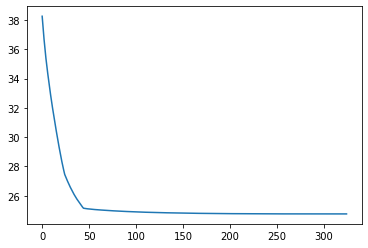

In [102]:
print([(i, h.MSE(W, X)) for i, W in enumerate(Ws)])
plt.plot([h.MSE(W, X) for W in Ws])

Shape of Psi (1, 1).
[[2086.62438643]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[2078.66467326]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1990.67401197]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1858.99465938]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[2005.2896793]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1666.12332605]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1636.36560175]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1664.61762766]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1576.70423394]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1480.42346278]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1582.44234125]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1547.03244389]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1441.12692168]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1461.03361274]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1479.05917844]]
Condition Number: 1.0.
Shape of Psi (1, 1).
[[1415.798869]]
Condition Number: 1.0.
Shape of Ps

Shape of Psi (4, 4).
[[1636.36560175 -354.52308252  -37.21373388   16.59288275]
 [-354.52308252 1441.12692168 -120.60026952  -42.36754302]
 [ -37.21373388 -120.60026952 1415.798869      1.72530063]
 [  16.59288275  -42.36754302    1.72530063 1206.53032916]]
Condition Number: 1.7120399595031988.
Shape of Psi (2, 2).
[[1415.798869     84.51567774]
 [  84.51567774 1369.57837391]]
Condition Number: 1.13427384111754.
Shape of Psi (4, 4).
[[1461.03361274   32.39871284   -7.44760619  -81.52775136]
 [  32.39871284 1441.12692168 -162.19592882  125.5277192 ]
 [  -7.44760619 -162.19592882 1664.61762766   25.85619521]
 [ -81.52775136  125.5277192    25.85619521 1547.03244389]]
Condition Number: 1.3786166863739135.
Shape of Psi (2, 2).
[[1369.57837391   48.83148446]
 [  48.83148446 1480.42346278]]
Condition Number: 1.109339047562512.
Shape of Psi (4, 4).
[[2086.62438643  437.17373109 -321.6348553    -9.63401366]
 [ 437.17373109 1664.61762766  -25.07624425 -162.19592882]
 [-321.6348553   -25.0762442

Shape of Psi (6, 6).
[[1308.07108157   98.75710212   84.43782008  -41.08436634   65.46524396
   -10.97331863]
 [  98.75710212 1636.36560175 -354.52308252  -37.21373388  -98.98340701
   115.17967785]
 [  84.43782008 -354.52308252 1441.12692168 -120.60026952   26.18700819
    -3.13624965]
 [ -41.08436634  -37.21373388 -120.60026952 1415.798869     60.16943073
    11.06842369]
 [  65.46524396  -98.98340701   26.18700819   60.16943073 2005.2896793
  -341.49833737]
 [ -10.97331863  115.17967785   -3.13624965   11.06842369 -341.49833737
  1990.67401197]]
Condition Number: 2.230014658967598.
Shape of Psi (10, 10).
[[ 2.07866467e+03  2.86071338e+02 -2.48709889e+02 -2.85430757e+02
   2.25079381e+01 -9.59955138e+00 -1.94434387e+01 -1.57697796e+01
   4.37933358e+01  1.48893666e+01]
 [ 2.86071338e+02  1.41579887e+03  4.59974028e+01 -8.22385375e+01
   5.42700312e+01 -3.29457992e+01  6.01694307e+01 -7.15513430e+00
  -1.64534131e+01  8.45156777e+01]
 [-2.48709889e+02  4.59974028e+01  1.45449049e+03  

Shape of Psi (4, 4).
[[1441.12692168  -88.82610177   52.96622549  -40.65283263]
 [ -88.82610177 1356.7885506   -51.02159001   86.41685604]
 [  52.96622549  -51.02159001 1666.12332605   82.38810725]
 [ -40.65283263   86.41685604   82.38810725 1324.262053  ]]
Condition Number: 1.3818038762480995.
Shape of Psi (5, 5).
[[1441.12692168  -88.82610177   52.96622549  -40.65283263  125.5277192 ]
 [ -88.82610177 1356.7885506   -51.02159001   86.41685604   25.88343467]
 [  52.96622549  -51.02159001 1666.12332605   82.38810725  -83.1335186 ]
 [ -40.65283263   86.41685604   82.38810725 1324.262053      4.42557662]
 [ 125.5277192    25.88343467  -83.1335186     4.42557662 1547.03244389]]
Condition Number: 1.4035345338759908.
Shape of Psi (9, 9).
[[ 2.08662439e+03  4.37173731e+02 -3.21634855e+02 -9.63401366e+00
   1.39472064e+01  1.16674756e+01 -1.00688465e+02 -1.07276091e+02
   1.25090787e-01]
 [ 4.37173731e+02  1.66461763e+03 -2.50762442e+01 -1.62195929e+02
  -8.10159874e+00  5.19177252e+01 -1.4721

Shape of Psi (8, 8).
[[ 1.41503376e+03 -1.33743375e+02 -2.56649871e+01 -8.22385375e+01
   7.45979871e+01  5.10579909e+01  7.03815220e+01 -3.03447108e+01]
 [-1.33743375e+02  1.85899466e+03 -1.74079018e+02 -1.04115408e+02
  -7.45084550e+01 -7.01415083e+00  1.64414290e+02  1.63277713e+02]
 [-2.56649871e+01 -1.74079018e+02  1.36957837e+03  8.45156777e+01
  -1.84186598e+00 -1.19334480e+01  3.78479015e+01 -1.73652337e+00]
 [-8.22385375e+01 -1.04115408e+02  8.45156777e+01  1.41579887e+03
  -3.15908724e+01 -3.29457992e+01 -1.20600270e+02  3.43208924e+01]
 [ 7.45979871e+01 -7.45084550e+01 -1.84186598e+00 -3.15908724e+01
   1.25324626e+03 -2.73840491e+01 -2.12714974e+01  1.55829052e+02]
 [ 5.10579909e+01 -7.01415083e+00 -1.19334480e+01 -3.29457992e+01
  -2.73840491e+01  1.35678855e+03 -8.88261018e+01 -4.09665481e+00]
 [ 7.03815220e+01  1.64414290e+02  3.78479015e+01 -1.20600270e+02
  -2.12714974e+01 -8.88261018e+01  1.44112692e+03 -2.20266229e+01]
 [-3.03447108e+01  1.63277713e+02 -1.73652337e+0

Shape of Psi (15, 15).
[[ 1.30807108e+03  9.87571021e+01  8.44378201e+01 -4.10843663e+01
   6.54652440e+01 -1.09733186e+01 -4.74402416e+01  1.10612470e+02
  -9.50675498e+01 -1.32236981e+01 -2.51879074e+01  2.76789530e+01
   1.61924350e+01  8.66428087e+01 -4.70891406e+01]
 [ 9.87571021e+01  1.63636560e+03 -3.54523083e+02 -3.72137339e+01
  -9.89834070e+01  1.15179678e+02 -3.63842198e+00 -3.09549475e+01
  -6.88969425e+01 -2.03273285e+01  9.57380054e+01  1.17590728e+01
   1.65928827e+01  4.40862976e+01 -1.91056152e+01]
 [ 8.44378201e+01 -3.54523083e+02  1.44112692e+03 -1.20600270e+02
   2.61870082e+01 -3.13624965e+00  7.03815220e+01  5.29662255e+01
  -2.20266229e+01 -8.88261018e+01 -1.62195929e+02 -8.19255481e+01
  -4.23675430e+01 -2.12714974e+01 -9.63401366e+00]
 [-4.10843663e+01 -3.72137339e+01 -1.20600270e+02  1.41579887e+03
   6.01694307e+01  1.10684237e+01 -8.22385375e+01  1.11902002e+00
   3.43208924e+01 -3.29457992e+01 -5.12010406e+01  2.86071338e+02
   1.72530063e+00 -3.15908724e+0

Shape of Psi (10, 10).
[[ 1.41579887e+03  8.45156777e+01 -9.37694207e+01 -1.20600270e+02
  -5.08687224e+01  9.89306197e+01  1.11902002e+00  5.42700312e+01
  -3.29457992e+01 -3.15908724e+01]
 [ 8.45156777e+01  1.36957837e+03 -9.38925244e-02  3.78479015e+01
   4.88314845e+01 -1.01552875e+02 -6.97679315e+01 -2.31241018e+00
  -1.19334480e+01 -1.84186598e+00]
 [-9.37694207e+01 -9.38925244e-02  1.32426205e+03 -4.06528326e+01
   3.51846651e+02  7.03901865e+01  8.23881072e+01  4.42557662e+00
   8.64168560e+01  6.36187176e+01]
 [-1.20600270e+02  3.78479015e+01 -4.06528326e+01  1.44112692e+03
   3.45921811e+00 -1.57376113e+01  5.29662255e+01  1.25527719e+02
  -8.88261018e+01 -2.12714974e+01]
 [-5.08687224e+01  4.88314845e+01  3.51846651e+02  3.45921811e+00
   1.48042346e+03  6.27829638e+01  8.54815497e+01  3.91658725e+01
   1.32042586e+02 -2.09277102e+01]
 [ 9.89306197e+01 -1.01552875e+02  7.03901865e+01 -1.57376113e+01
   6.27829638e+01  1.34179248e+03  2.86987339e+02 -6.76139297e+00
  -5.88418

Shape of Psi (12, 12).
[[ 1.41503376e+03 -1.33743375e+02 -2.56649871e+01 -8.22385375e+01
   7.45979871e+01  5.10579909e+01  7.03815220e+01 -3.03447108e+01
   2.97453759e+01 -1.45795409e+02  1.04003505e+01 -2.16285301e-02]
 [-1.33743375e+02  1.85899466e+03 -1.74079018e+02 -1.04115408e+02
  -7.45084550e+01 -7.01415083e+00  1.64414290e+02  1.63277713e+02
   9.85102208e-01  1.18173070e+02  2.56923453e+01 -2.65871595e+01]
 [-2.56649871e+01 -1.74079018e+02  1.36957837e+03  8.45156777e+01
  -1.84186598e+00 -1.19334480e+01  3.78479015e+01 -1.73652337e+00
  -9.38925244e-02 -2.31241018e+00 -6.97679315e+01 -1.01552875e+02]
 [-8.22385375e+01 -1.04115408e+02  8.45156777e+01  1.41579887e+03
  -3.15908724e+01 -3.29457992e+01 -1.20600270e+02  3.43208924e+01
  -9.37694207e+01  5.42700312e+01  1.11902002e+00  9.89306197e+01]
 [ 7.45979871e+01 -7.45084550e+01 -1.84186598e+00 -3.15908724e+01
   1.25324626e+03 -2.73840491e+01 -2.12714974e+01  1.55829052e+02
   6.36187176e+01 -2.42421618e+02  3.11112238e+01

  -2.42421618e+02  5.42700312e+01 -4.53493979e+01  1.54703244e+03]]
Condition Number: 3.4858590601454686.
Shape of Psi (6, 6).
[[1356.7885506     2.15301849  -58.84187432   25.88343467  -27.38404906
   -51.02159001]
 [   2.15301849 1206.53032916  -20.56482404  -15.17440345   -2.33408357
    -3.55051501]
 [ -58.84187432  -20.56482404 1341.79247915   -6.76139297  -64.32035075
   286.98733941]
 [  25.88343467  -15.17440345   -6.76139297 1547.03244389 -242.42161833
   -83.1335186 ]
 [ -27.38404906   -2.33408357  -64.32035075 -242.42161833 1253.2462588
    31.11122379]
 [ -51.02159001   -3.55051501  286.98733941  -83.1335186    31.11122379
  1666.12332605]]
Condition Number: 1.7259933774121294.
Shape of Psi (20, 20).
[[ 2.07866467e+03  2.86071338e+02 -2.48709889e+02 -2.85430757e+02
   2.25079381e+01 -9.59955138e+00 -1.94434387e+01 -1.57697796e+01
   4.37933358e+01  1.48893666e+01 -2.95484770e+01  1.76048520e+02
   1.17590728e+01 -8.19255481e+01 -7.74887399e+00 -8.63948550e+00
  -5.17342262e

Shape of Psi (14, 14).
[[ 1.41503376e+03 -1.33743375e+02 -2.56649871e+01 -8.22385375e+01
   7.45979871e+01  5.10579909e+01  7.03815220e+01 -3.03447108e+01
   2.97453759e+01 -1.45795409e+02  1.04003505e+01 -2.16285301e-02
  -2.91412484e+01  5.15733034e+01]
 [-1.33743375e+02  1.85899466e+03 -1.74079018e+02 -1.04115408e+02
  -7.45084550e+01 -7.01415083e+00  1.64414290e+02  1.63277713e+02
   9.85102208e-01  1.18173070e+02  2.56923453e+01 -2.65871595e+01
  -1.03288327e+02  1.53446087e+01]
 [-2.56649871e+01 -1.74079018e+02  1.36957837e+03  8.45156777e+01
  -1.84186598e+00 -1.19334480e+01  3.78479015e+01 -1.73652337e+00
  -9.38925244e-02 -2.31241018e+00 -6.97679315e+01 -1.01552875e+02
   8.82143743e+01  4.88314845e+01]
 [-8.22385375e+01 -1.04115408e+02  8.45156777e+01  1.41579887e+03
  -3.15908724e+01 -3.29457992e+01 -1.20600270e+02  3.43208924e+01
  -9.37694207e+01  5.42700312e+01  1.11902002e+00  9.89306197e+01
   1.72530063e+00 -5.08687224e+01]
 [ 7.45979871e+01 -7.45084550e+01 -1.84186598

   5.94642041e+01  1.75113296e+01 -1.33743375e+02  1.41503376e+03]]
Condition Number: 3.1480907208779296.
Shape of Psi (24, 24).
[[ 1.30807108e+03  9.87571021e+01  8.44378201e+01 -4.10843663e+01
   6.54652440e+01 -1.09733186e+01 -4.74402416e+01  1.10612470e+02
  -9.50675498e+01 -1.32236981e+01 -2.51879074e+01  2.76789530e+01
   1.61924350e+01  8.66428087e+01 -4.70891406e+01  6.90144177e+01
  -4.60709650e+01  5.83110453e+01 -1.71073022e+01 -8.06579267e+01
  -1.82736571e+01  6.74049705e+01  1.24743386e+02  2.34528658e+01]
 [ 9.87571021e+01  1.63636560e+03 -3.54523083e+02 -3.72137339e+01
  -9.89834070e+01  1.15179678e+02 -3.63842198e+00 -3.09549475e+01
  -6.88969425e+01 -2.03273285e+01  9.57380054e+01  1.17590728e+01
   1.65928827e+01  4.40862976e+01 -1.91056152e+01 -2.47668594e+01
  -1.02276282e+02  6.26203892e+01  7.85179275e+00 -4.52414915e+02
  -3.59621772e+01 -4.40931960e+01 -5.02068947e+01  2.02203342e+01]
 [ 8.44378201e+01 -3.54523083e+02  1.44112692e+03 -1.20600270e+02
   2.618700

Shape of Psi (24, 24).
[[ 2.07866467e+03  2.86071338e+02 -2.48709889e+02 -2.85430757e+02
   2.25079381e+01 -9.59955138e+00 -1.94434387e+01 -1.57697796e+01
   4.37933358e+01  1.48893666e+01 -2.95484770e+01  1.76048520e+02
   1.17590728e+01 -8.19255481e+01 -7.74887399e+00 -8.63948550e+00
  -5.17342262e+01  2.34827464e+01 -2.70144597e+01  4.11156340e+02
   1.50921372e+02  2.66224893e+01  2.82836504e+02  5.91152350e+01]
 [ 2.86071338e+02  1.41579887e+03  4.59974028e+01 -8.22385375e+01
   5.42700312e+01 -3.29457992e+01  6.01694307e+01 -7.15513430e+00
  -1.64534131e+01  8.45156777e+01 -9.37694207e+01  2.10541733e+01
  -3.72137339e+01 -1.20600270e+02  1.11902002e+00 -5.08687224e+01
  -1.04115408e+02  1.72530063e+00  3.43208924e+01  1.10684237e+01
   5.67670606e+01 -3.15908724e+01 -5.12010406e+01  9.89306197e+01]
 [-2.48709889e+02  4.59974028e+01  1.45449049e+03  1.75113296e+01
   6.11247803e+01 -2.47173374e+00  2.44417353e+02  2.93449601e+01
   1.44210646e+01  2.63538917e+01 -2.50325897e+01 -

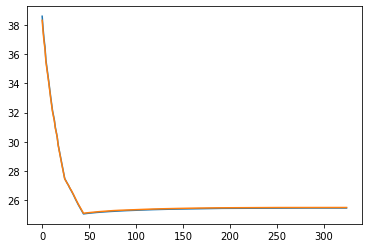

In [103]:
covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(A_true.T, A_true.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
W, Ws, _, condition_numbers = K_OMP(X[:-1].T.dot(X[:-1]), X[:-1].T.dot(X[1:]), [np.dot(y.T, y) for y in X[1:].T], X[:-1].T, normalize = True, F = [], tol = -0.99)
print(covariance_X)
print(np.cov(X.T))

def expected_cost_var(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true.T, W_true.T)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    # covariance matrix
    covariance_matrix = Sigma + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

print(np.round(Ws[7]))
print(np.round(Ws[8]))
plt.plot([expected_cost_var(A_true, W) for W in Ws])

X_long = h.generate_var_2(10000, p, A_true, np.identity(p))
plt.plot([h.MSE(W, X_long) for W in Ws])

In [81]:
print(Ws[64])

[[ 3.11157469e-01  5.76210799e-01  3.78965696e-01  0.00000000e+00
   0.00000000e+00  3.79282246e+00  4.11127500e-01  5.51711826e-01
   6.82596230e-01  0.00000000e+00  1.19073850e-01 -1.20828559e-01]
 [ 0.00000000e+00  8.57311771e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.32996570e+01 -3.37784781e-01  4.73305577e-01
   0.00000000e+00  0.00000000e+00  4.42361678e-02 -1.11919644e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.26186960e-01]
 [-1.10987636e-02 -1.25063821e-01  0.00000000e+00  5.36954810e-01
   0.00000000e+00 -3.32133260e+00  4.12399584e-01  1.97447981e-01
   0.00000000e+00  3.41763849e-01 -1.83982434e-01  0.00000000e+00]
 [ 1.55104529e+00  5.81932991e-01  1.16458608e+00 -8.14290723e-01
   4.50975351e-01 -4.39235672e+01  8.93253602e-01  0.00000000e+00
   0.00000000e+00 -1.39193443e-01  0.00000000e+00  0.00000000e+00]
 [ 0.